In [2]:

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

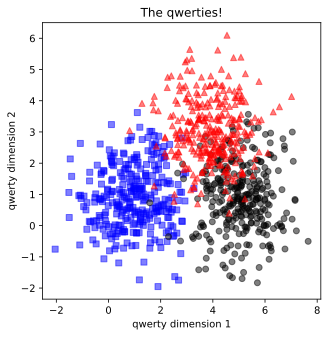

In [3]:
# create data

nPerClus = 300
blur = 1
A = [1,1]
B = [5,1]
C = [4,3]

a = [A[0]+np.random.randn(nPerClus)*blur , A[1]+np.random.randn(nPerClus)*blur]
b = [B[0]+np.random.randn(nPerClus)*blur , B[1]+np.random.randn(nPerClus)*blur]
c = [C[0]+np.random.randn(nPerClus)*blur , C[1]+np.random.randn(nPerClus)*blur]

# true labels
labels_np = np.hstack((
    np.zeros((nPerClus)),
    np.ones((nPerClus)),
    1+np.ones((nPerClus))
))

# concatanate into matrix 
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note : "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=0.5)
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [5]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

# convert them to PyTorch DataSets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batch_size = 16
train_laoder = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_laoder = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [8]:
# create a class for the model
def createTheQwertyNet(momentum):
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(2,8)
            
            ### hidden layer
            self.fc1 = nn.Linear(8,8)
            
            ### output layer
            self.output = nn.Linear(8,3)
            
        def forward(self,x):
            x = self.input(x)
            x = F.relu(x)
            x = F.relu(self.fc1(x))
            x = self.output(x)
            return x
    
    # create the model instance
    net = qwertyNet()

    # loss function
    lossFn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01,momentum=momentum)
    
    return net,lossFn,optimizer

In [9]:
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [12]:
# number of epoches
num_epochs = 100
    

def funcTrainModel(momentum):
    
    
    # create a new model
    net,lossFn,optimizer = createTheQwertyNet(momentum)
    
    # init losses
    losses = torch.zeros(num_epochs)
    trainAcc = []
    testAcc = []
    
    # loop through epochs
    for epochI in range(num_epochs):
        
        # switch on training mode
        net.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X,y in train_laoder:
            
            yHat = net(X)
            loss = lossFn(yHat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            # compute acc
            matches = torch.argmax(yHat,dim=1) == y # bool (false/true)
            matchNumeric = matches.float() # convert to numbers (0/1)
            accPct = 100*torch.mean(matchNumeric) # avg and x100
            batchAcc.append(accPct)
        
        trainAcc.append(np.mean(batchAcc))
        
        # avg losses across batches
        losses[epochI] = np.mean(batchLoss)
        
        # test acc
        net.eval()
        X,y = next(iter(test_laoder))
        with torch.no_grad():
            yHat = net(X)
            
        testAcc.append(100*torch.mean((torch.argmax(yHat,dim=1) == y).float()))
    # end epochs    
    return trainAcc,testAcc,losses,net

In [13]:
momenta = [0,.5,.9,.95,.999]

results = np.zeros((num_epochs,len(momenta),3))

for idx,momentum in enumerate(momenta):
    trainAcc,testAcc,losses,net = funcTrainModel(momentum)
    results[:,idx,0] = losses
    results[:,idx,1] = trainAcc
    results[:,idx,2] = testAcc
    

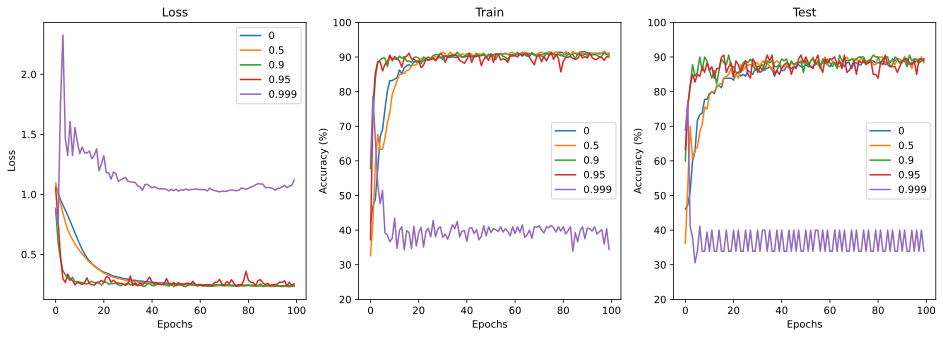

In [14]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
    ax[i].plot(results[:,:,i])
    ax[i].legend(momenta)
    ax[i].set_xlabel('Epochs')
    if i == 0:
        ax[i].set_ylabel('Loss')
    else:
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([20,100])

ax[0].set_title('Loss')
ax[1].set_title("Train")
ax[2].set_title('Test')

plt.show()